<a href="https://colab.research.google.com/github/NatSy77/projet_7/blob/main/P7_modelisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implémentez un modèle de scoring #modelisetion

In [ ]:
import gc
gc.collect()  # Collecte la mémoire non utilisée

68

## Importation

In [ ]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.3/28.3 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.4/647.4 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.6 MB/s eta 0:00:00


In [ ]:
!pip install lightgbm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# List files available
print(os.listdir("/content/drive/MyDrive/Colab Notebooks/DS_projet_7/data_modelisation/"))

['app_test.csv', 'app_train.csv']


In [ ]:
#importation fichier
app_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DS_projet_7/data_modelisation/app_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 242)


,Unnamed: 0,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM
0,0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,False,False,False,False,True,False,True,False,1,False
1,1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,False,False,False,False,False,False,True,False,0,False
2,2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,False,False,False,False,False,False,False,False,0,False
3,3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,False,False,False,False,False,False,False,False,0,False
4,4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,False,False,False,False,False,False,False,False,0,False


In [ ]:
# Testing data features
app_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DS_projet_7/data_modelisation/app_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 241)


,Unnamed: 0,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,0,100001,0,0,1,0,135000.0,568800.0,20560.5,450000.0,...,False,False,False,False,False,True,False,True,False,False
1,1,100005,0,0,1,0,99000.0,222768.0,17370.0,180000.0,...,False,False,False,False,False,False,False,False,False,False
2,2,100013,0,1,1,0,202500.0,663264.0,69777.0,630000.0,...,False,False,False,False,False,False,False,False,False,False
3,3,100028,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,...,False,False,False,False,True,False,False,True,False,False
4,4,100038,0,1,0,1,180000.0,625500.0,32067.0,625500.0,...,False,False,False,False,False,False,False,False,False,False


## Exploration

In [ ]:
app_train['TARGET'].value_counts()

,count
TARGET,
0,282686
1,24825


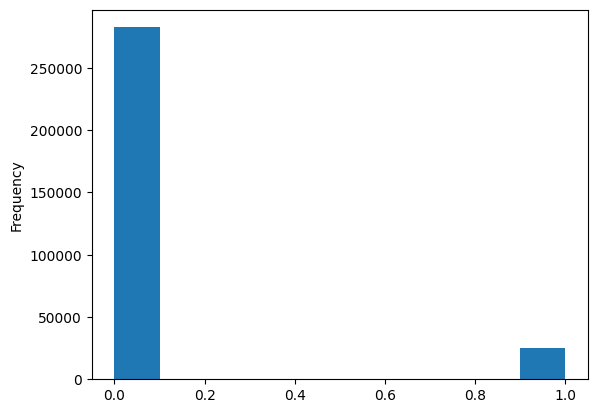

In [ ]:
app_train['TARGET'].astype(int).plot.hist();

In [ ]:
# Number of each type of column
app_train.dtypes.value_counts()

,count
bool,132
float64,66
int64,44


In [ ]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 242)
Testing Features shape:  (48744, 241)


In [ ]:
import re

# Supprimer la colonne 'Unnamed: 0' si elle existe
app_train = app_train.drop(columns=['Unnamed: 0'], errors='ignore')
app_test = app_test.drop(columns=['Unnamed: 0'], errors='ignore')

# Nettoyer les noms de colonnes
def clean_column_names(df):
    df.columns = (
        df.columns
        .str.strip()  # Supprime les espaces en début et fin
        .str.replace(r"[^\w]", "_", regex=True)  # Remplace tous les caractères non-alphanumériques par "_"
    )
    return df

app_train = clean_column_names(app_train)
app_test = clean_column_names(app_test)

# Modélisation

### Préparation de l'environement

In [ ]:
!pip install mlflow pyngrok

In [ ]:
import os
from pyngrok import ngrok
import mlflow
import mlflow.sklearn  # Pour enregistrer les modèles scikit-learn

In [ ]:
mlflow_directory = "/content/drive/MyDrive/Colab Notebooks/DS_projet_7/mlflow"
os.makedirs(mlflow_directory, exist_ok=True)
mlflow.set_tracking_uri(f"file://{mlflow_directory}")

### Chargement des données et préparation

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import pandas as pd

# Chargement des données
if 'TARGET' in app_train.columns:
    train = app_train.drop(columns=['TARGET'])
    target = app_train['TARGET']
else:
    train = app_train.copy()
    target = None

# Vérification des valeurs manquantes avec SimpleImputer
if train.isnull().sum().sum() > 0:
    imputer = SimpleImputer(strategy='median')
    train = pd.DataFrame(imputer.fit_transform(train), columns=train.columns)  # Conserver les noms des colonnes
else:
    train = train.copy()  # Conversion explicite si déjà propre

# Diviser les données en ensembles d'entraînement et de test (si `target` est défini)
if target is not None:
    X_train, X_test, y_train, y_test = train_test_split(
        train, target, test_size=0.2, random_state=42
    )
else:
    X_train, X_test, y_train, y_test = None, None, None, None
    print("Attention : Aucune étiquette ('target') n'a été fournie.")

# Appliquer la même transformation sur les données de test
app_test = app_test.drop(columns=['TARGET'], errors='ignore')  # Enlever la colonne TARGET si elle existe
app_test = pd.DataFrame(imputer.transform(app_test), columns=app_test.columns)  # Conserver les noms des colonnes

In [ ]:
print("Colonnes de train :", train.columns.tolist())

Colonnes de train : ['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENT

### Initialisation de MLflow

In [ ]:
import mlflow
import os

# Créer le répertoire mlflow s'il n'existe pas
mlflow_directory = "/content/drive/MyDrive/Colab Notebooks/DS_projet_7/mlflow"
os.makedirs(mlflow_directory, exist_ok=True)

# Définir l'URI de suivi MLflow
mlflow.set_tracking_uri(f"file://{mlflow_directory}")

# Définir l'expérience
mlflow.set_experiment("Multi-Model Experiment lightgbm score metier")

#Model Experiment 3 LightGBM : scale_pos_weight + bagging_fraction & pos_bagging_fraction
#Model Experiment 3 LightGBM 06c338951b22474bae75bcaf73dfd006 : scale_pos_weight (seuil optimal : 0,1)
#Model Experiment 3 LightGBM 6384c7a1e96c4d7088902ac022cd934c : (erreur scaler is_unbalance=True) scale_pos_weight (seuil optimal : 0,55)
#Model Experiment 3 LightGBM SMOTE b0270a2828ce47cb80fea07e96fbecd4 : changement du calcul score metier

<Experiment: artifact_location=('file:///content/drive/MyDrive/Colab '
 'Notebooks/DS_projet_7/mlflow/706359919036996243'), creation_time=1737912440232, experiment_id='706359919036996243', last_update_time=1737912440232, lifecycle_stage='active', name='Multi-Model Experiment lightgbm score metier', tags={}>

In [ ]:
input_example = X_train.iloc[[1]].values  # Obtenir les valeurs de la deuxième ligne (index 1)

### Préparation des outils et des données

In [ ]:
target.value_counts(normalize=True)  # Vérifie la proportion de chaque classe

,proportion
TARGET,
0,0.919271
1,0.080729


### Ajout d’une pipeline et Optimisation des hyperparamètres
Créer une pipeline pour standardiser le traitement, incluant SMOTE, la normalisation, et le modèle.

Intégration de RandomizedSearchCV pour trouver les meilleurs hyperparamètres d’un modèle dans une pipeline.

In [ ]:
import time
import joblib
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from mlflow.sklearn import load_model, log_model
from joblib import Parallel, delayed
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
# Calculer la proportion des classes
from collections import Counter
# Import the necessary class
from lightgbm import LGBMClassifier

#### hyperparamètres
- **learning_rate**	Contrôle la vitesse d'apprentissage du modèle (petite valeur = apprentissage lent mais stable, grande valeur = apprentissage rapide mais risque d'overfitting).
- **n_estimators**	Nombre total d'arbres dans le modèle (plus d'arbres = meilleure généralisation, mais plus de temps de calcul).
- **max_depth**	Profondeur maximale des arbres (évite l'overfitting, mais limite la capacité d'apprentissage). None pour laisser l'algorithme décider.
- **num_leaves**	Nombre maximal de feuilles par arbre (plus de feuilles = plus de complexité). Par défaut, 31 est souvent un bon compromis.
- **min_child_samples**	Nombre minimal d'échantillons requis dans un nœud pour qu'il soit divisé (évite le sur-ajustement).
- **subsample**	Fraction des données utilisées pour chaque arbre (empêche l'overfitting, aide la généralisation).
- **colsample_bytree**	Fraction des features utilisées pour chaque arbre (évite l'overfitting et accélère l'entraînement).
- **min_split_gain**	Gain minimum requis pour diviser un nœud (évite les splits inutiles).
- **lambda_l1**	Régularisation L1 (encourage la sparsité des poids pour éviter l'overfitting).
- **lambda_l2**	Régularisation L2 (évite les poids trop élevés pour stabiliser l'apprentissage).
- **scale_pos_weight**	Poids des classes pour gérer le déséquilibre (ex: si classe 1 est 10x plus rare, mettre 10).

**Je couvre les principaux paramètres qui influencent l'overfitting, la vitesse d’apprentissage, et l'équilibre des classes**

In [ ]:
class_counts = Counter(y_train)  # Compte des classes
y_train_negative = class_counts[0]  # Classe négative (étiquetée comme 0)
y_train_positive = class_counts[1]  # Classe positive (étiquetée comme 1)

In [ ]:
models_with_params = {
    "LightGBM": {
        "model": LGBMClassifier(is_unbalance=True, random_state=42),
        "params": {
            'model__learning_rate': [0.03, 0.05],  # Plus lent mais plus stable
            'model__n_estimators': [200, 300, 400],  # Plus d’arbres pour plus de robustesse
            'model__max_depth': [10, 15],  # Permet de capturer plus d’interactions sans sur-apprentissage
            'model__num_leaves': [31, 50, 70],  # Teste plus de feuilles pour voir plus de structures
            'model__min_child_samples': [5, 10, 20],  # Ajuste la granularité des sous-groupes
            'model__bagging_fraction': [0.7, 0.8],  # Ajustement fin du sous-échantillonnage
            'model__colsample_bytree': [0.6, 0.8, 1.0],  # Utilisation de plus de features par arbre
            #'model__scale_pos_weight': [6, 7, 8, 9],  # Meilleur équilibre entre FP et FN
            'model__pos_bagging_fraction': [0.6, 0.7]  # Ajustement du rééquilibrage dans les mini-batches
        }
    }
}

In [ ]:
"""# Dictionnaire des modèles avec leurs hyperparamètres

models_with_params = {
    "LightGBM": {
        "model": LGBMClassifier(random_state=42),
        "params": {
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'model__n_estimators': [50, 100, 200, 300],
            'model__max_depth': [10, 15, 20],  # Teste des profondeurs plus élevées
            'model__num_leaves': [31, 50, 70],  # Teste plus de feuilles
            'model__min_child_samples': [10, 50, 100],
            'model__bagging_fraction': [0.6, 0.8],  # Teste 60% et 80% de données par itération
            'model__colsample_bytree': [0.6, 0.8, 1.0],
            'model__min_split_gain': [0.0, 0.1, 0.2],
            'model__lambda_l1': [0.0, 0.1, 0.5],  # Diminue la régularisation L1
            'model__lambda_l2': [0.0, 0.1, 0.5],  # Diminue la régularisation L2
            'model__scale_pos_weight': [5, 7, 9],  # Équilibre mieux `TARGET=1`
            'model__pos_bagging_fraction': [0.6, 0.7],  # Augmente encore la part de `TARGET=1`
        }
    }
}"""

'# Dictionnaire des modèles avec leurs hyperparamètres\n\nmodels_with_params = {\n    "LightGBM": {\n        "model": LGBMClassifier(random_state=42),\n        "params": {\n            \'model__learning_rate\': [0.01, 0.05, 0.1, 0.2],\n            \'model__n_estimators\': [50, 100, 200, 300],\n            \'model__max_depth\': [10, 15, 20],  # Teste des profondeurs plus élevées\n            \'model__num_leaves\': [31, 50, 70],  # Teste plus de feuilles\n            \'model__min_child_samples\': [10, 50, 100],\n            \'model__bagging_fraction\': [0.6, 0.8],  # Teste 60% et 80% de données par itération\n            \'model__colsample_bytree\': [0.6, 0.8, 1.0],\n            \'model__min_split_gain\': [0.0, 0.1, 0.2],\n            \'model__lambda_l1\': [0.0, 0.1, 0.5],  # Diminue la régularisation L1\n            \'model__lambda_l2\': [0.0, 0.1, 0.5],  # Diminue la régularisation L2\n            \'model__scale_pos_weight\': [5, 7, 9],  # Équilibre mieux `TARGET=1`\n            \'mode

#### score métier
Coûts différenciés

La fonction utilise deux paramètres, cost_fnet cost_fp, avec par défaut cost_fn=10et cost_fp=1 : le coût d'un faux négatif doit être dix fois supérieur à celui d'un faux positif.

Calcul du coût total

La méthode calcule le coût total en multipliant le nombre de faux négatifs par cost_fnet le nombre de faux positifs par cost_fppuis en faisant la somme.
Ce calcul permet d'obtenir une mesure globale de l'impact financier sur l'ensemble du jeu de données , ce qui est pertinent dans le contexte métier.

L'optimisation du seuil est dans la boucle

In [ ]:
def custom_cost_function(y_true, y_pred, cost_fn=10, cost_fp=1):
    """
    Calcul d'un score métier basé sur le coût des erreurs.

    Args:
    y_true (array-like): Valeurs réelles.
    y_pred (array-like): Prédictions du modèle.
    cost_fn (int): Coût d'un faux négatif.
    cost_fp (int): Coût d'un faux positif.

    Returns:
    float: Coût total des erreurs.
    """
    # Matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calcul du coût total
    total_cost = (cost_fp * fp) + (cost_fn * fn)
    return total_cost

#### RandomizedSearchCV
RandomizedSearchCV est souvent plus efficace que GridSearchCV, car il permet d’explorer un large espace d’hyperparamètres avec moins de calculs.

- Avantages de RandomizedSearchCV :

Il teste un sous-ensemble aléatoire des combinaisons possibles, ce qui est beaucoup plus rapide que de tester toutes les combinaisons (GridSearchCV).
Il est idéal pour des modèles avec beaucoup d’hyperparamètres, comme LightGBM.

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

In [ ]:
# experimentation 3 param augmenté
def train_pipeline(model_name, model, params, X_train, y_train):
    print(f"\nEntraînement du pipeline pour {model_name}...")

    # Création du pipeline
    pipeline = ImbPipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('model', model)
    ])

    # Initialisation de RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=params,
        n_iter=20,
        scoring='roc_auc',
        cv=3,
        n_jobs=-1,
        random_state=42
    )

    try:
        # Entraîner le modèle
        random_search.fit(X_train, y_train)

        # Sauvegarde du meilleur modèle
        joblib.dump(random_search.best_estimator_, f'pipeline_{model_name}.pkl')
        print(f"Pipeline pour {model_name} sauvegardé sous le nom pipeline_{model_name}.pkl")

        # Sauvegarder les résultats de recherche
        results_df = pd.DataFrame(random_search.cv_results_)
        results_df.to_csv(f'results_{model_name}.csv', index=False)
        print(f"Résultats sauvegardés dans results_{model_name}.csv")

        return random_search.best_params_

    except Exception as e:
        print(f"Erreur lors de l'entraînement du pipeline pour {model_name} : {e}")
        return None

#### training

In [ ]:
if __name__ == "__main__":
    # Vérifier si les données sont disponibles et ont une forme correcte
    if X_train is not None and y_train is not None:
        if X_train.shape[0] != y_train.shape[0]:
            print("Erreur : Le nombre d'exemples dans X_train et y_train ne correspond pas.")
        else:
            results = {}

            # Parcourir les modèles du dictionnaire et les entraîner un par un
            for model_name, model_data in models_with_params.items():
                print(f"\nEntraînement du modèle : {model_name}")

                try:
                    # Entraîner le modèle et récupérer les meilleurs hyperparamètres
                    best_params = train_pipeline(
                        model_name=model_name,
                        model=model_data["model"],
                        params=model_data["params"],
                        X_train=X_train,
                        y_train=y_train
                    )

                    results[model_name] = best_params
                    print(f"Meilleurs paramètres pour {model_name} : {best_params}")
                except Exception as e:
                    print(f"Erreur lors de l'entraînement de {model_name} : {e}")

            # Afficher les résultats finaux
            print("\nRésultats finaux :")
            for model, params in results.items():
                print(f"{model}: {params}")
    else:
        print("Erreur : Les données d'entraînement ne sont pas disponibles.")


Entraînement du modèle : LightGBM

Entraînement du pipeline pour LightGBM...
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.468108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11717
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 235
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
Pipeline pour LightGBM sauvegardé sous le nom pipeline_LightGBM.pkl
Résultats sauvegardés dans results_LightGBM.csv
Meilleurs paramètres pour LightGBM : {'model__pos_bagging_fraction': 0.7, 

### Boucle sur plusieurs modèles avec journalisation MLflow

In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix
print(f"scikit-learn version: {sklearn.__version__}")

scikit-learn version: 1.6.1


In [ ]:
# Liste des modèles
models = {
    "LightGBM": LGBMClassifier(is_unbalance=True, random_state=42)  # Paramètre pour gérer les classes déséquilibrées
}

In [ ]:
# Liste pour stocker les courbes ROC
roc_curves = []

In [ ]:
# Répertoire pour les sorties
output_dir = "mlflow_outputs"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Boucle sur chaque modèle
for model_name, model in models.items():
    start_time = time.time()

    try:
        # === Définir la pipeline ===
        pipeline = ImbPipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('model', model)
        ])

        # === Entraîner la pipeline ===
        pipeline.fit(X_train, y_train)

        # Sauvegarder la pipeline localement
        pipeline_path = os.path.join(output_dir, f'pipeline_{model_name}.pkl')
        joblib.dump(pipeline, pipeline_path)

        # === Prédictions ===
        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, "predict_proba") else None

        # === Calcul des métriques ===
        total_cost = custom_cost_function(y_test, y_pred, cost_fn=10, cost_fp=1)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

        # === Ajustement du seuil pour minimiser le coût personnalisé ===
        optimal_threshold = None
        if y_prob is not None:
            thresholds = np.arange(0.1, 1.0, 0.05)
            costs = []

            for threshold in thresholds:
                y_pred_class = (y_prob >= threshold).astype(int)
                cost = custom_cost_function(y_test, y_pred_class, cost_fn=10, cost_fp=1)
                costs.append(cost)

            optimal_threshold = thresholds[np.argmin(costs)]
            print(f"Optimal Threshold: {optimal_threshold}")

        # === MLflow : Enregistrement ===
        with mlflow.start_run(run_name=model_name):
            # Paramètres du modèle
            mlflow.log_param("model_name", model_name)

            # Enregistrer les meilleurs hyperparamètres
            if isinstance(model, RandomizedSearchCV):
                best_params = model.best_params_
                for param_name, param_value in best_params.items():
                    mlflow.log_param(param_name, param_value)
            else:
                # En cas de modèle simple (sans recherche hyperparamétrique)
                if hasattr(model, "n_estimators"):
                    mlflow.log_param("n_estimators", model.n_estimators)
                if hasattr(model, "max_depth"):
                    mlflow.log_param("max_depth", model.max_depth)
                if hasattr(model, "learning_rate"):
                    mlflow.log_param("learning_rate", model.learning_rate)

            # Enregistrer les métriques
            mlflow.log_metric("custom_cost", total_cost)
            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("f1_score", f1)
            mlflow.log_metric("precision", precision)
            mlflow.log_metric("recall", recall)
            if auc_roc is not None:
                mlflow.log_metric("auc_roc", auc_roc)

            # Enregistrer le seuil optimal
            if optimal_threshold is not None:
                mlflow.log_param("optimal_threshold", optimal_threshold)

            # Enregistrer le pipeline complet
            joblib.dump(model, f'{model_name}_pipeline.pkl')
            mlflow.log_artifact(f'{model_name}_pipeline.pkl')

            # Journaliser la pipeline dans MLflow
            input_example = pd.DataFrame(X_train[:1])  # Exemple d'entrée pour le modèle
            log_model(
                sk_model=pipeline,
                artifact_path="model_pipeline",
                input_example=input_example
            )

            # === Courbe ROC ===
            if y_prob is not None:
                plt.figure()
                fpr, tpr, _ = roc_curve(y_test, y_prob)
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
                plt.plot([0, 1], [0, 1], 'k--')
                plt.title(f'ROC Curve - {model_name}')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.legend(loc="lower right")
                roc_curve_path = os.path.join(output_dir, f"roc_curve_{model_name}.png")
                plt.savefig(roc_curve_path)
                plt.close()
                mlflow.log_artifact(roc_curve_path)

            # Enregistrer le temps d'exécution
            elapsed_time = time.time() - start_time
            mlflow.log_metric("training_time", elapsed_time)

        print(f"Modèle {model_name} journalisé avec succès.")
    except Exception as e:
        print(f"Erreur lors de l'entraînement du modèle {model_name}: {e}")

[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.244496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11711
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 232
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
Optimal Threshold: 0.5500000000000002
Modèle LightGBM journalisé avec succès.


Metriques :
- **F1-Score**
Le F1-score est une métrique qui combine précision et rappel en un seul score harmonique. C'est utile lorsque vous avez un déséquilibre entre les classes, car il pénalise les modèles qui sacrifient l'une au profit de l'autre.

Utilisé lorsque les faux positifs (FP) et faux négatifs (FN) sont également importants.

- **AUC-ROC (Area Under the Curve - Receiver Operating Characteristic)**
L'AUC-ROC mesure la capacité d'un modèle à discriminer entre les classes positives et négatives, en testant différents seuils de probabilité.
Interprétation de l'AUC :
AUC = 1 : Parfaite séparation des classes.
AUC = 0.5 : Modèle aléatoire (aucune capacité de discrimination).
AUC < 0.5 : Mauvais modèle (inversion des classes).

Utile pour comparer des modèles indépendamment d'un seuil spécifique.

- **Précision (Precision)**
La précision mesure la proportion de vrais positifs parmi tous les échantillons prédits comme positifs.

Utile lorsque les faux positifs sont coûteux.

- **Rappel (Recall ou Sensibilité)**
Le rappel mesure la proportion de vrais positifs parmi tous les échantillons qui sont effectivement positifs.

- **Temps de calcul**
mesurer le temps de calcul de chaque modèle

Utile lorsque les faux négatifs sont coûteux.

Précision vs Rappel : Il existe souvent un compromis entre précision et rappel. Une augmentation de l'un peut réduire l'autre.
F1-Score : Trouve un équilibre entre précision et rappel.
AUC-ROC : Évalue la performance globale sur tous les seuils.

En utilisant ces prédictions :

* Précision : Parmi les clients que le modèle dit éligibles, combien le sont vraiment ?
* Rappel : Parmi les clients réellement éligibles, combien le modèle détecte-t-il ?
* F1-Score : Moyenne harmonique de la précision et du rappel.
* AUC-ROC : Mesure la capacité du modèle à distinguer entre les deux classes sur tous les seuils possibles.

Ces métriques permettent de choisir le modèle qui répond le mieux à vos objectifs métier et aux coûts associés aux erreurs de classification.

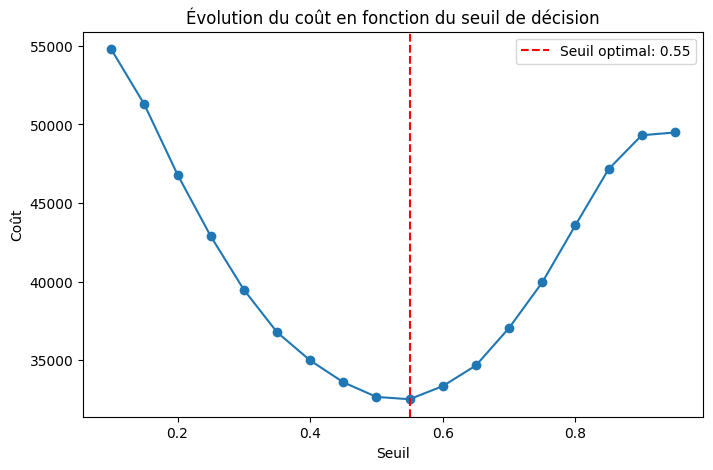

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Recalculer les coûts pour chaque seuil
thresholds = np.arange(0.1, 1.0, 0.05)
costs = []

for threshold in thresholds:
    y_pred_class = (y_prob >= threshold).astype(int)
    cost = custom_cost_function(y_test, y_pred_class, cost_fn=10, cost_fp=1)
    costs.append(cost)

# Tracer le graphique du coût en fonction du seuil
plt.figure(figsize=(8, 5))
plt.plot(thresholds, costs, marker='o', linestyle='-')
plt.xlabel("Seuil")
plt.ylabel("Coût")
plt.title("Évolution du coût en fonction du seuil de décision")
plt.axvline(optimal_threshold, color='r', linestyle='--', label=f"Seuil optimal: {optimal_threshold:.2f}")
plt.legend()
plt.show()


In [ ]:
thresholds = np.arange(0.1, 1.0, 0.05)
costs = []

for threshold in thresholds:
    y_pred_class = (y_prob >= threshold).astype(int)
    cost = custom_cost_function(y_test, y_pred_class, cost_fn=10, cost_fp=1)
    costs.append(cost)

optimal_threshold = thresholds[np.argmin(costs)]
print(f"Nouveau seuil optimal après ajustement des classes: {optimal_threshold}")

Nouveau seuil optimal après ajustement des classes: 0.5500000000000002


### Lancer l'interface MLflow UI
Utilisation d'une interface web distante via ngrok(exposée au public), créer un compte et récupérer le token

In [ ]:
!ngrok authtoken 2qlJq50YUC2X62MFA1q7qxbILkY_5Dx45MFSwjmUQLvcqSHBU

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!mlflow ui --backend-store-uri "file:///content/drive/MyDrive/Colab Notebooks/DS_projet_7/mlflow" --port 5000 &

[2025-02-05 08:54:25 +0000] [10035] [INFO] Starting gunicorn 23.0.0
[2025-02-05 08:54:25 +0000] [10035] [INFO] Listening at: http://127.0.0.1:5000 (10035)
[2025-02-05 08:54:25 +0000] [10035] [INFO] Using worker: sync
[2025-02-05 08:54:25 +0000] [10036] [INFO] Booting worker with pid: 10036
[2025-02-05 08:54:25 +0000] [10037] [INFO] Booting worker with pid: 10037
[2025-02-05 08:54:25 +0000] [10038] [INFO] Booting worker with pid: 10038
[2025-02-05 08:54:25 +0000] [10043] [INFO] Booting worker with pid: 10043
[2025-02-05 08:55:14 +0000] [10035] [CRITICAL] WORKER TIMEOUT (pid:10038)
[2025-02-05 08:55:15 +0000] [10038] [ERROR] Error handling request /ajax-api/2.0/mlflow/runs/search
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gunicorn/workers/sync.py", line 134, in handle
    self.handle_request(listener, req, client, addr)
  File "/usr/local/lib/python3.11/dist-packages/gunicorn/workers/sync.py", line 177, in handle_request
    respiter = self.wsgi(en

[2025-02-05 09:08:49 +0000] [10035] [INFO] Handling signal: int
[2025-02-05 09:08:50 +0000] [10376] [INFO] Worker exiting (pid: 10376)
[2025-02-05 09:08:50 +0000] [10505] [INFO] Worker exiting (pid: 10505)
[2025-02-05 09:08:50 +0000] [10310] [INFO] Worker exiting (pid: 10310)
[2025-02-05 09:08:50 +0000] [10268] [INFO] Worker exiting (pid: 10268)
[2025-02-05 09:08:51 +0000] [10035] [INFO] Shutting down: Master


In [ ]:
from pyngrok import conf, ngrok

# Définir le token dans la configuration
conf.get_default().auth_token = "2qlJq50YUC2X62MFA1q7qxbILkY_5Dx45MFSwjmUQLvcqSHBU"

# Démarrer le tunnel
public_url = ngrok.connect(5000)
print(f"Interface MLflow accessible à : {public_url}")

Interface MLflow accessible à : NgrokTunnel: "https://f634-34-81-168-95.ngrok-free.app" -> "http://localhost:5000"


In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-9)  # Évite division par 0
optimal_threshold_f1 = thresholds[f1_scores.argmax()]

print(f"Seuil optimal basé sur F1-score : {optimal_threshold_f1}")

Seuil optimal basé sur F1-score : 0.66427882037548


In [ ]:
# arrêter le tunnel ngrok
#ngrok.disconnect(public_url)

#### Analyse des résultats du modèle
Coût personnalisé :

Un coût de 32900 est relativement élevé, ce qui pourrait indiquer que des erreurs spécifiques (faux positifs ou faux négatifs) pèsent beaucoup dans votre fonction de coût.
Précision (accuracy, 0.6989) :

Une précision proche de 70 % est correcte mais peut être trompeuse si les classes sont déséquilibrées. Cela explique probablement pourquoi l'AUC ROC est plus significatif ici.
F1-score (0.2657) :

Un score F1 modéré, mais faible, indique que l'équilibre entre précision et rappel est difficile à atteindre. La faible précision (16,5 %) tire le score F1 vers le bas.
Rappel (0.6771) :

Un bon rappel (68 % environ) montre que le modèle identifie bien les cas positifs, mais il sacrifie de la précision pour y parvenir.
AUC ROC (0.7583) :

Un AUC supérieur à 0,75 est un bon signe que le modèle discrimine correctement entre les classes, malgré un déséquilibre.

chemin pipeline drive : file:///content/drive/MyDrive/Colab Notebooks/DS_projet_7/mlflow/706359919036996243/60d8b21cb8234d7fb49ce8a7d3ce505d/artifacts/LightGBM_pipeline.pkl

Faire des prédictions
Prédire sur un DataFrame Pandas :
import mlflow
logged_model = 'runs:/60d8b21cb8234d7fb49ce8a7d3ce505d/model_pipeline'


coût_personnalisé
32663
précision
0,6991041087426629
f1_score
0,2673212447541373
précision
0,1662317199271259
rappel
0,6821580117195393
auc_roc
0,7584402922755487
durée_de_formation
41.26594352722168